**This notebook can be used to generate the plots found in the paper, once the experiments have been run**

Define imports and general configuration parameters

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import warnings
import matplotlib.patches as mpatches
plt.rcParams.update({'font.size': 8})
plt.rcParams["legend.markerscale"] = 0.3

Define the indexes (as fraction of 1) for warm up and cool down.
E.g., 0.1 and 0.9 mean the first 10% of the data is discarded (warm up) and the last 10% of the data is discarded (cool down)

In [2]:
wu_i = 0.1 # Warm Up Index
cd_i = 0.9 # Cool Down Index

Specifies number of repetitions (for each experiment)

In [3]:
reps = 1

Specify which statistics should be plotted. You can choose between any subset of ['injectionRate', 'throughput', 'latency', 'outputRate']

In [4]:
stats = ['injectionRate', 'throughput', 'latency', 'outputRate']

Specify which operators are being evaluated, you can choose any subset of ['flatmap', 'join']

In [5]:
ops = ['flatmap', 'join']

Now specify, for each operator, which experiments IDs have been run. Notice the following IDs are valid: 'LLF', 'ALF', 'HLF', 'LHF', 'AHF', 'HHF', 'llf', 'alf', 'hlf', 'lhf', 'ahf', 'hhf' for flatmap, and 'LLJ', 'ALJ', 'HLJ', 'LHJ', 'AHJ', 'HHJ', 'llj', 'alj', 'hlj', 'lhj', 'ahj', 'hhj' for join

In [6]:
experiments_per_operator = {'join': ['LLJ', 'ALJ', 'HLJ', 'LHJ', 'AHJ', 'HHJ'], 'flatmap': ['LLF', 'ALF', 'HLF', 'LHF', 'AHF', 'HHF']} # High-end server
# experiments_per_operator = {'join': ['llj', 'alj', 'hlj', 'lhj', 'ahj', 'hhj'], 'flatmap': ['llf', 'alf', 'hlf', 'lhf', 'ahf', 'hhf']} # Odroid

The following is a support function that reads the log file produced by the experiments scripts. The format is predefined, so this function should not be modified

In [7]:
def read_exp_log(logfile):
    headers = ['folder', 'repetition', 'rate', 'sleep', 'outcome']
    out = pd.read_csv(logfile, header=None, names=headers)
    out['repetition'].iloc[1:] = pd.to_numeric(out['repetition'].iloc[1:])
    out['rate'].iloc[1:] = pd.to_numeric(out['rate'].iloc[1:])
    out['sleep'].iloc[1:] = pd.to_numeric(out['sleep'].iloc[1:])
    out['outcome'].iloc[1:] = pd.to_numeric(out['outcome'].iloc[1:])
    return out

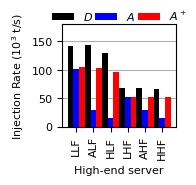

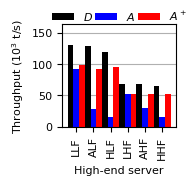

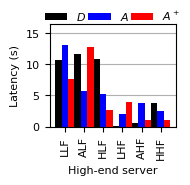

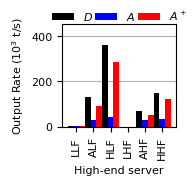

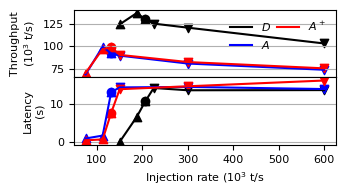

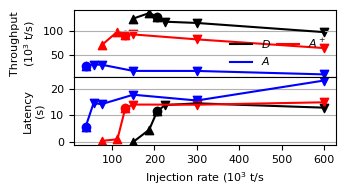

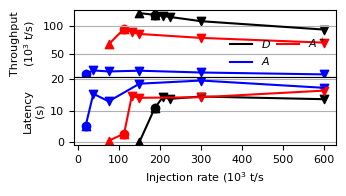

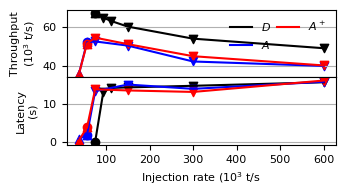

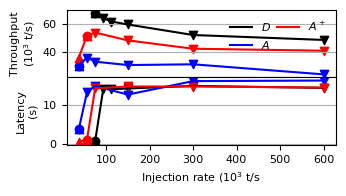

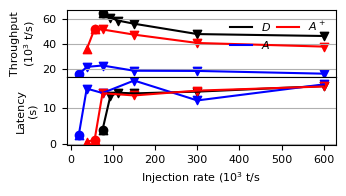

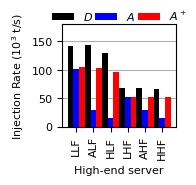

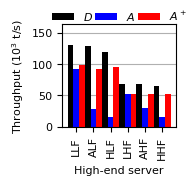

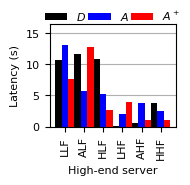

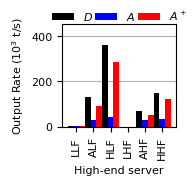

FileNotFoundError: [Errno 2] No such file or directory: '/home/vincenzo/aggregates_for_the_win_code/java/aggspes/data/output_files/joinwikipedia/LLJ/NATIVE/2000000/0/join_native_injectionRate.csv'

In [11]:



stats_ylabels = {'injectionRateflatmap': r'Injection Rate ($10^3$ t/s)', 'throughputflatmap': r'Throughput ($10^3$ t/s)', 'latencyflatmap': 'Latency (s)', 'outputRateflatmap': r'Output Rate ($10^3$ t/s)',
    'injectionRatejoin': r'Injection Rate ($10^3$ t/s)', 'throughputjoin': r'Throughput ($10^3$ c/s)', 'latencyjoin': 'Latency (s)', 'outputRatejoin': r'Output Rate ($10^3$ t/s)'}


throughput_metric_per_operator = {'join': r'$10^3$ c/s', 'flatmap': r'$10^3$ t/s'}
base_folder = '/home/vincenzo/aggregates_for_the_win_code/java/aggspes/data/output_files/'

# This are the labels we are going to use in the different plots and for the managing of data to create
# the plots
implementations_labels = ['native', 'aggbased1', 'aggbasedM']
# These maps our labels with those used in Java
# implementations_ids = {'native': 'native',
#                        'aggbased1': 'aggbased', 'aggbasedM': 'aggbased'}
implementations_enums = {'native': 'NATIVE',
                       'aggbased1': 'SINGLEOUT', 'aggbasedM': 'MULTIOUT'}
# These maps our labels with colors for plots
implementations_colors = {'native': 'black',
                          'aggbased1': 'blue', 'aggbasedM': 'red'}
implementations_legend = {'native': r'$D$', 'aggbased1': r'$A$', 'aggbasedM': r'$A^+$'}

for o in range(len(ops)):

    operator = ops[o]
    experiments = experiments_per_operator[operator]

    data_folders = dict()
    data_folders['native'] = base_folder + operator+'wikipedia/'
    data_folders['aggbased1'] = base_folder + operator+'wikipedia/'
    data_folders['aggbasedM'] = base_folder + operator+'wikipedia/'

    explogs = dict()
    # Read experiments log
    explogs['native'] = read_exp_log(data_folders['native']+'log.txt')
    explogs['aggbased1'] = read_exp_log(data_folders['aggbased1']+'log.txt')
    explogs['aggbasedM'] = read_exp_log(data_folders['aggbasedM']+'log.txt')

    # Add keys to overall_data
    overall_data = dict()
    for statistic in stats:
        for implementation in implementations_labels:
            overall_data[statistic+'_'+implementation] = []

    for repetition in range(0, reps):

        # Add keys to repetition_best_result_data
        repetition_best_result_data = dict()
        for statistic in stats:
            for implementation in implementations_labels:
                repetition_best_result_data[statistic+'_'+implementation] = []

        # repetition_all_results_data is going to be plotted by repetition, by experiment, and by statistic
        pd_data = pd.DataFrame(columns=[
                               'repetition', 'experiment', 'implementation_type', 'stat', 'valueMean', 'valueQ99', 'outcome'])

        for i in range(len(stats)):

            statistic = stats[i]

            for experiment in experiments:

                for implementation in implementations_labels:

                    # Filter on experiment and implementation type
                    relevant_exps = explogs[implementation].loc[explogs[implementation]['folder'].str.contains(
                        experiment+'/'+implementations_enums[implementation], case=False)]
                    # Filter on repetition
                    relevant_exps = relevant_exps.loc[relevant_exps['repetition'] == repetition]
                    successful_relevant_exps = relevant_exps.loc[relevant_exps['outcome'] == 1]

                    min_successful_period_throughput = successful_relevant_exps['sleep'].min()
                    min_successful_period_latency = successful_relevant_exps['sleep'].min()
                    #successful_relevant_exps.sort_values(by='sleep')['sleep'].iloc[2]

                    # Rather than reading only the relevant one, we can read all of them and store the data to create the plot
                    # First we sort in decreasing order for the sleep period
                    relevant_exps = relevant_exps.sort_values(
                        by='sleep', ascending=False)

                    # Now read one by one based on the sleep period and store the data
                    for [period, outcome] in zip(relevant_exps.sleep, relevant_exps.outcome):

                        file_to_read = data_folders[implementation]+experiment+'/'+implementations_enums[implementation]+'/'+str(period)+'/'+str(
                            repetition)+'/'+operator+'_'+implementations_enums[implementation]+'_'+statistic+'.csv'
                        df = pd.read_csv(
                            file_to_read, header=None, names=['ts', 'v'])

                        # Compute start and end index
                        row_count = len(df.v)
                        start_index = int(row_count * wu_i)
                        end_index = int(row_count * cd_i)

                        # Notice -1 values are ignored. Lor latency it meas no outputs, for rates is always >= 0!
                        temp = df.v.iloc[start_index:end_index]
                        temp = temp.loc[temp >= 0]

                        if period == min_successful_period_latency and statistic == 'latency':
                            repetition_best_result_data[statistic + '_' + implementation].append(temp.quantile(0.99)/1000)
                        elif period == min_successful_period_throughput and statistic != 'latency':
                            repetition_best_result_data[statistic +'_'+implementation].append(temp.mean()/1000)

                        # Storing data in pd_data
                        new_row = {'targetRate': [(1e9/period)/1000],'repetition': [repetition], 'experiment': [experiment], 'implementation_type': [
                            implementation],  'stat': [statistic],  'valueMean': [temp.mean()/1000],  'valueQ99': [temp.quantile(0.99)/1000], 'outcome': [outcome], 'pickedAsMaxThroughput': [1 if period == min_successful_period_throughput else 0], 'pickedAsLatency': [1 if period == min_successful_period_latency else 0]}
                        pd_data = pd.concat([pd_data, pd.DataFrame(new_row)])

            
            this_barplot_fig, this_barplot_axs = plt.subplots(1, 1, figsize=(1.9, 2))
            this_barplot_axs.grid(True, axis='y')

            x = np.arange(len(experiments))  # the label locations
            width = 0.333  # the width of the bars

            rects1 = this_barplot_axs.bar(
                x - width, repetition_best_result_data[statistic+'_native'], width, label=r'$D$', color=implementations_colors['native'])
            rects2 = this_barplot_axs.bar(
                x, repetition_best_result_data[statistic+'_aggbased1'], width, label=r'$A$', color=implementations_colors['aggbased1'])
            rects3 = this_barplot_axs.bar(
                x + width, repetition_best_result_data[statistic+'_aggbasedM'], width, label=r'$A^+$', color=implementations_colors['aggbasedM'])

            this_barplot_axs.set_xticks(x, experiments,rotation=90)
            this_barplot_axs.set_xlabel('High-end server')
            this_barplot_axs.set_ylabel(stats_ylabels[statistic+operator])

            # Increase the y limit for the labels to fit
            ymin, ymax = this_barplot_axs.get_ylim()
            this_barplot_axs.set_ylim([ymin, ymax*1.2])

            this_barplot_axs.legend(ncol=3,frameon=False, borderpad=0,columnspacing=0.2,markerscale=3,loc='upper center', bbox_to_anchor=(0.5, 1.2))
        
            this_barplot_fig.tight_layout()
            plt.gca().set_axisbelow(True)
            this_barplot_fig.savefig(base_folder + operator+'_'+statistic +
                                '_statistic_rep_'+str(repetition)+'_barplot.pdf')

            for implementation in implementations_labels:
                overall_data[statistic+'_'+implementation].append(
                    repetition_best_result_data[statistic+'_'+implementation])

        # At this point we have all the stats (throughput, latency, and outputRate) for all experiments, we can plot for this repetition and all experiments
        for e in range(len(experiments)):
            experiment = experiments[e]
            global_index = (pd_data['repetition'] == repetition) & (
                pd_data['experiment'] == experiment)

            this_scalability_fig, this_scalability_axs = plt.subplots(2, 1, figsize=(3.5, 2), sharex=True, gridspec_kw={'hspace': 0})
            this_scalability_axs[0].grid(True, axis='y')
            this_scalability_axs[1].grid(True, axis='y')

            for implementation in implementations_labels:

                index = global_index & (
                    pd_data['implementation_type'] == implementation)

                # Plot injection rate vs throughput
                # In this case I am reading targetRate instead of valueMean to plot the expected injection rate rather then the observed one
                this_scalability_axs[0].plot(pd_data.loc[index & (pd_data['stat'] == 'injectionRate')]['targetRate'], pd_data.loc[index & (
                    pd_data['stat'] == 'throughput')]['valueMean'], color=implementations_colors[implementation], label=implementations_legend[implementation])
                # plot markers
                this_scalability_axs[0].scatter(pd_data.loc[index & (pd_data['stat'] == 'injectionRate') & (
                    pd_data['outcome'] == 1)]['targetRate'], pd_data.loc[index & (pd_data['stat'] == 'throughput') & (pd_data['outcome'] == 1)]['valueMean'], marker='^', color=implementations_colors[implementation])
                this_scalability_axs[0].scatter(pd_data.loc[index & (pd_data['stat'] == 'injectionRate') & (
                    pd_data['outcome'] == 0)]['targetRate'], pd_data.loc[index & (pd_data['stat'] == 'throughput') & (pd_data['outcome'] == 0)]['valueMean'], marker='v', color=implementations_colors[implementation])
                this_scalability_axs[0].scatter(pd_data.loc[index & (pd_data['stat'] == 'injectionRate') & (
                    pd_data['pickedAsMaxThroughput'] == 1)]['targetRate'], pd_data.loc[index & (pd_data['stat'] == 'throughput') & (pd_data['pickedAsMaxThroughput'] == 1)]['valueMean'], marker='o', color=implementations_colors[implementation])

            this_scalability_axs[0].set_ylabel(r'Throughput'+'\n'+r'('+throughput_metric_per_operator[operator]+r')')

            for implementation in implementations_labels:

                index = global_index & (
                    pd_data['implementation_type'] == implementation)

                # Plot injection rate vs latency
                # In this case I am reading targetRate instead of valueMean to plot the expected injection rate rather then the observed one
                this_scalability_axs[1].plot(pd_data.loc[index & (pd_data['stat'] == 'injectionRate')]['targetRate'], pd_data.loc[index & (
                    pd_data['stat'] == 'latency')]['valueQ99'], color=implementations_colors[implementation], label=implementation)
                # plot markers
                this_scalability_axs[1].scatter(pd_data.loc[index & (pd_data['stat'] == 'injectionRate') & (
                    pd_data['outcome'] == 1)]['targetRate'], pd_data.loc[index & (pd_data['stat'] == 'latency') & (pd_data['outcome'] == 1)]['valueQ99'], marker='^', color=implementations_colors[implementation])
                this_scalability_axs[1].scatter(pd_data.loc[index & (pd_data['stat'] == 'injectionRate') & (
                    pd_data['outcome'] == 0)]['targetRate'], pd_data.loc[index & (pd_data['stat'] == 'latency') & (pd_data['outcome'] == 0)]['valueQ99'], marker='v', color=implementations_colors[implementation])
                this_scalability_axs[1].scatter(pd_data.loc[index & (pd_data['stat'] == 'injectionRate') & (
                    pd_data['pickedAsLatency'] == 1)]['targetRate'], pd_data.loc[index & (pd_data['stat'] == 'latency') & (pd_data['pickedAsLatency'] == 1)]['valueQ99'], marker='o', color=implementations_colors[implementation])

            this_scalability_axs[1].set_xlabel(r'Injection rate ($10^3$ t/s')

            this_scalability_axs[1].set_ylabel(r'Latency'+'\n'+r'(s)')

            this_scalability_axs[0].legend(ncol=2,frameon=False,columnspacing=0.5,markerscale=0.5)

            this_scalability_fig.tight_layout()
            plt.gca().set_axisbelow(True)
            this_scalability_fig.savefig(base_folder + operator + '_'+experiment+'_rep_'+str(repetition)+'_scalability.pdf')

    for i in range(len(stats)):

        statistic = stats[i]

        this_barplot_fig, this_barplot_axs = plt.subplots(1, 1, figsize=(1.9, 2))
        this_barplot_axs.grid(True, axis='y')

        x = np.arange(len(experiments))  # the label locations
        width = 0.333  # the width of the bars

        rects1 = this_barplot_axs.bar(
            x - width, np.mean(overall_data[statistic+'_native'], 0), width, label=r'$D$', color=implementations_colors['native'])
        rects2 = this_barplot_axs.bar(
            x, np.mean(overall_data[statistic+'_aggbased1'], 0), width, label=r'$A$', color=implementations_colors['aggbased1'])
        rects3 = this_barplot_axs.bar(
            x + width, np.mean(overall_data[statistic+'_aggbasedM'], 0), width, label=r'$A^+$', color=implementations_colors['aggbasedM'])

        this_barplot_axs.set_xticks(x, experiments,rotation=90)
        this_barplot_axs.set_xlabel('High-end server')
        this_barplot_axs.set_ylabel(stats_ylabels[statistic+operator])

        ymin, ymax = this_barplot_axs.get_ylim()
        this_barplot_axs.set_ylim([ymin, ymax*1.2])

        this_barplot_axs.legend(ncol=3,frameon=False, borderpad=0,columnspacing=0.2,markerscale=0.5,loc='upper center', bbox_to_anchor=(0.5, 1.2))
        
        this_barplot_fig.tight_layout()
        plt.gca().set_axisbelow(True)
        # this_barplot_fig.subplots_adjust(right=0.99)
        this_barplot_fig.savefig(base_folder + operator+"_" +
                            statistic+'_mean_barplot.pdf')

    plt.show()
